In [219]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [220]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import missingno as msno
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [221]:
train = pd.read_csv("data/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [222]:
test = pd.read_csv("data/test.csv")
PassengerId = test["PassengerId"]
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Label Check

Survived is well distributed

<Axes: ylabel='Survived'>

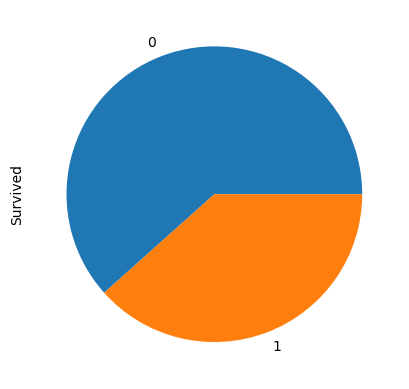

In [223]:
train.Survived.value_counts().plot(kind="pie")

### Null Check

<Axes: >

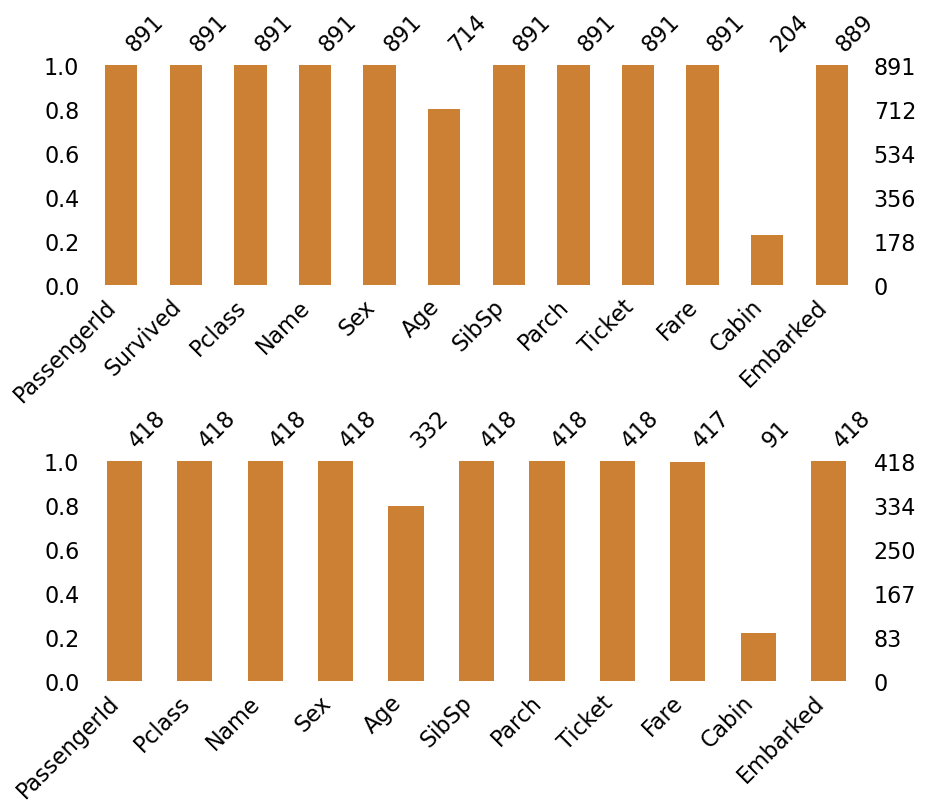

In [224]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.8)

msno.bar(df=train, figsize=(10, 8), color=(0.8, 0.5, 0.2), ax=ax1)
msno.bar(df=test, figsize=(10, 8), color=(0.8, 0.5, 0.2), ax=ax2)

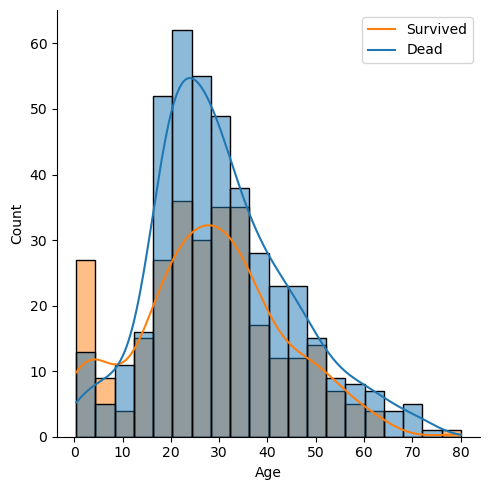

In [225]:
age_mean = train.Age.mean()
age_std = train.Age.std()
sns.displot(train, x="Age", hue="Survived", kde=True, legend=False)
plt.legend(labels=["Survived", "Dead"])

Skewness-train: 4.79 Skewness-test: 3.69


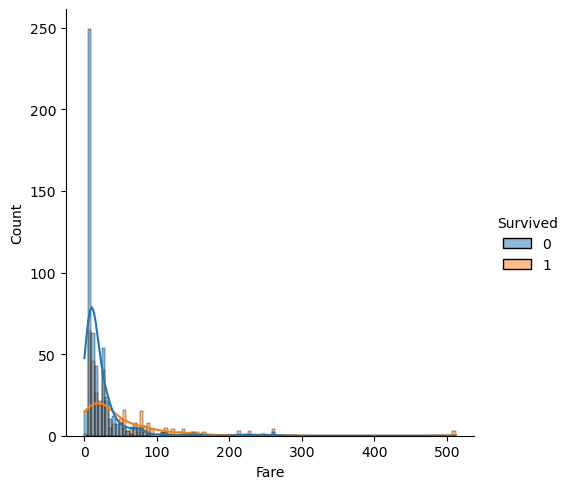

In [226]:
median_Fare = train.Fare.median()

train["Fare"] = train.Fare.fillna(median_Fare)
test["Fare"] = test.Fare.fillna(median_Fare)

sns.displot(train, x="Fare", hue="Survived", kde=True)

print(
    "Skewness-train: {:.2f}".format(train.Fare.skew()),
    "Skewness-test: {:.2f}".format(test.Fare.skew()),
)

In [227]:
def get_title(name):
    if re.search("([a-zA-Z]+)\.", name):
        return re.search("([a-zA-Z]+)\.", name)[1]
    return

In [228]:
full_data = [train, test]

for data in full_data:
    data["Title"] = data.Name.apply(get_title)
    data["Title"] = data.Title.replace(["Miss", "Mlle", "Lady"], "Ms")
    data["Title"] = data.Title.replace(["Countess", "Mme", "Dona"], "Mrs")
    data["Title"] = data.Title.replace(["Don", "Sir", "Jonkheer", "Master"], "Mr")
    data["Title"] = data.Title.replace(["Major", "Col", "Capt"], "Military")
    data["Title"] = data.Title.map(
        {"Mr": 0, "Ms": 1, "Mrs": 2, "Military": 3, "Dr": 4, "Rev": 5}
    )

In [229]:
mode_Embarked = train.Embarked.mode()[0]

for data in full_data:
    data["Sex"] = data.Sex.map({"male": 0, "female": 1})

    age_null_size = data.Age.isnull().sum()
    ages_random = np.random.randint(
        age_mean - age_std, age_mean + age_std, size=age_null_size
    )
    data.Age[data.Age.isnull()] = ages_random

    data["FamilySize"] = data.SibSp + data.Parch + 1

    data["IsAlone"] = 0
    data["IsAlone"][data.FamilySize == 1] = 1

    data["HasCabin"] = data.Cabin.apply(lambda x: 0 if type(x) == float else 1)

    data["Embarked"] = data.Embarked.fillna(mode_Embarked)
    data["Embarked"] = data.Embarked.map({"S": 0, "C": 1, "Q": 2})

In [230]:
y_train = train.Survived
X_train = train.drop(
    ["Survived", "PassengerId", "Cabin", "SibSp", "Parch", "Name", "Ticket"], axis=1
)
X_test = test.drop(["PassengerId", "Cabin", "SibSp", "Parch", "Name", "Ticket"], axis=1)
X_train.head()

,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,IsAlone,HasCabin
0,3,0,22.0,7.2500,0,0,2,0,0
1,1,1,38.0,71.2833,1,2,2,0,1
2,3,1,26.0,7.9250,0,1,1,1,0
3,1,1,35.0,53.1000,0,2,2,0,1
4,3,0,35.0,8.0500,0,0,1,1,0


<Axes: >

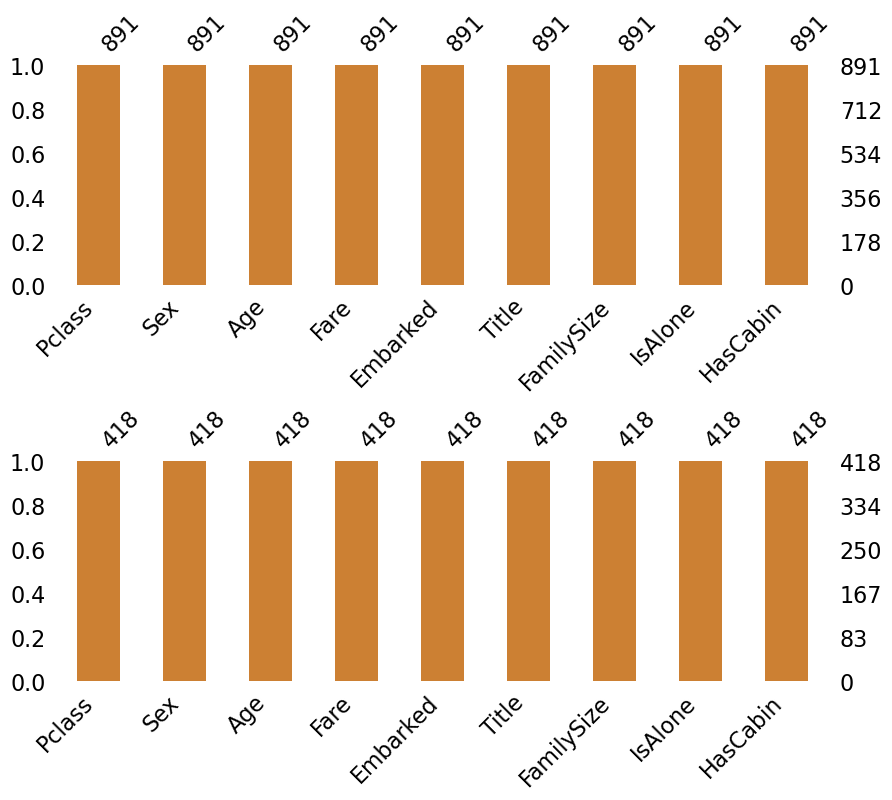

In [231]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.8)

msno.bar(df=X_train, figsize=(10, 8), color=(0.8, 0.5, 0.2), ax=ax1)
msno.bar(df=X_test, figsize=(10, 8), color=(0.8, 0.5, 0.2), ax=ax2)

<Axes: title={'center': 'Pearson Correlation of Features'}>

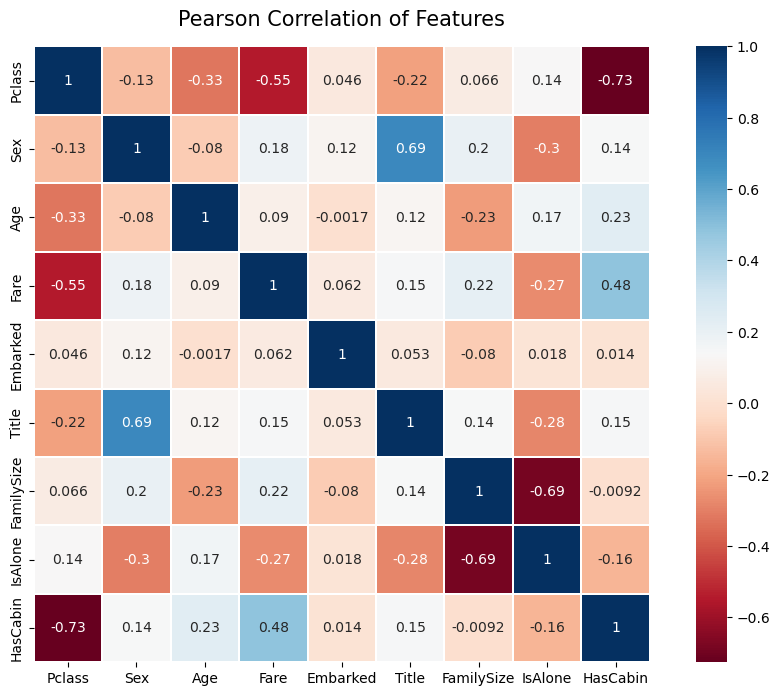

In [232]:
plt.figure(figsize=(12, 8))
plt.title("Pearson Correlation of Features", y=1.02, size=15)
sns.heatmap(
    X_train.corr(),
    linewidths=0.1,
    vmax=1.0,
    square=True,
    cmap=plt.cm.RdBu,
    linecolor="white",
    annot=True,
)

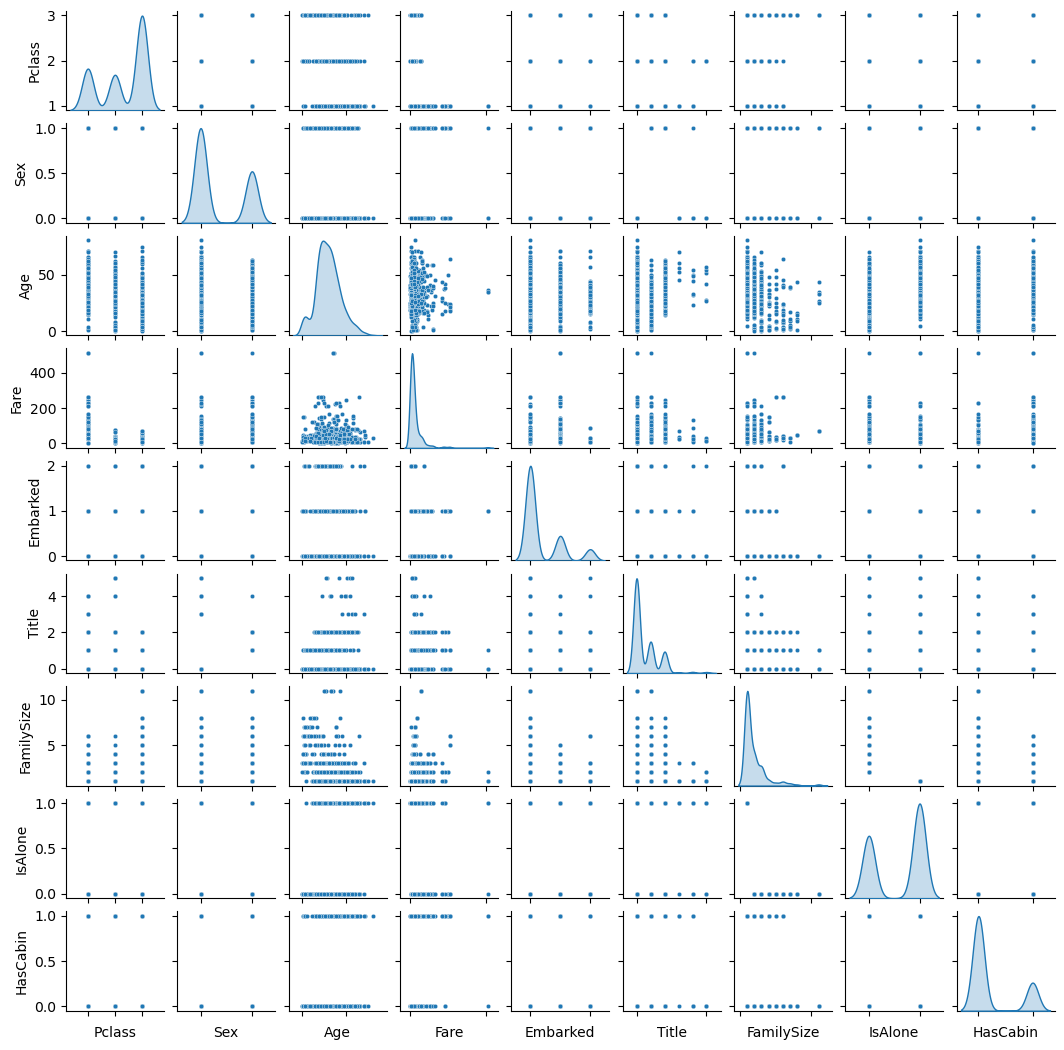

In [233]:
g = sns.pairplot(
    X_train,
    palette="seismic",
    size=1.2,
    diag_kind="kde",
    diag_kws=dict(shade=True),
    plot_kws=dict(s=10),
)
g.set(xticklabels=[])

In [234]:
def grid_search_cv(model, params, X, y, cv=5, scoring="accuracy"):
    grid_search = GridSearchCV(model, params, cv=cv, scoring=scoring)
    grid_search.fit(X, y)
    print("Best score: {}".format(grid_search.best_score_))
    print("Best params: {}".format(grid_search.best_params_))

    return grid_search

In [235]:
def grid_heatmap(grid_search, params):
    xlabel, ylabel = params.keys()
    results = pd.DataFrame(grid_search.cv_results_)

    heatmap = sns.heatmap(
        results.mean_test_score.to_numpy().reshape(
            len(params[ylabel]), len(params[xlabel])
        ),
        vmax=1,
        square=True,
        cmap=plt.cm.RdBu,
        annot=True,
        xticklabels=params[xlabel],
        yticklabels=params[ylabel],
    )
    heatmap.set(xlabel=xlabel, ylabel=ylabel)

Best score: 0.818209779674848
Best params: {'max_depth': 7, 'min_samples_leaf': 4}


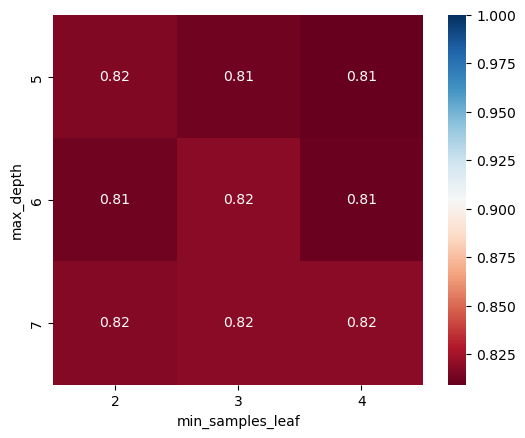

In [236]:
models = []

param_grid = {
    "min_samples_leaf": [2, 3, 4],  # on x-axis
    "max_depth": [5, 6, 7],  # on y-axis
}
grid = grid_search_cv(RandomForestClassifier(), param_grid, X_train, y_train)
grid_heatmap(grid, param_grid)
models.append(("rf", grid.best_estimator_))
# results = pd.DataFrame(grid.cv_results_)
# display(results)

Best score: 0.808122528403741
Best params: {'max_depth': 5, 'min_samples_leaf': 3}


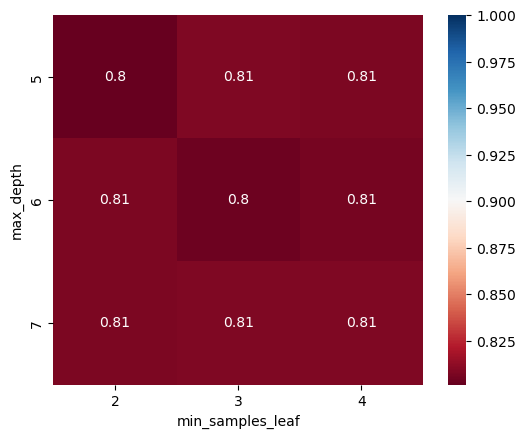

In [237]:
param_grid = {
    "min_samples_leaf": [2, 3, 4],
    "max_depth": [5, 6, 7],
}
grid = grid_search_cv(ExtraTreesClassifier(), param_grid, X_train, y_train)
grid_heatmap(grid, param_grid)
models.append(("et", grid.best_estimator_))

In [238]:
param_grid = {
    "n_estimators": [100, 500],
    "learning_rate": [0.1, 0.5, 1],
}
grid = grid_search_cv(AdaBoostClassifier(), param_grid, X_train, y_train)
grid_heatmap(grid, param_grid)
models.append(("ada", grid.best_estimator_))

Best score: 0.8316615403929445
Best params: {'max_depth': 4, 'min_samples_leaf': 2}


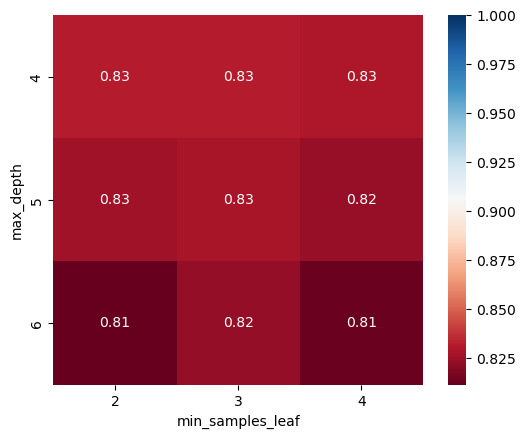

In [ ]:
param_grid = {
    "min_samples_leaf": [2, 3, 4],
    "max_depth": [4, 5, 6],
}
grid = grid_search_cv(GradientBoostingClassifier(), param_grid, X_train, y_train)
grid_heatmap(grid, param_grid)
models.append(("gb", grid.best_estimator_))

In [ ]:
final = LogisticRegression()
st = StackingClassifier(estimators=models, final_estimator=final, cv=5)
st.fit(X_train, y_train)
print("Training set score: {:.3f}".format(st.score(X_train, y_train)))
predictions = st.predict(X_test)

Training set score: 0.908


In [ ]:
result = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions})
result.to_csv("result.csv", index=False)